# 2. Partive families

[HP10] M. Habib and C. Paul, “A survey of the algorithmic aspects of modular decomposition,” Computer Science Review, vol. 4, no. 1, pp. 41–59, Feb. 2010, doi: [10.1016/j.cosrev.2010.01.001](https://doi.org/10.1016/j.cosrev.2010.01.001).

In [1]:
import networkx as nx
from typing import Set, Iterable, List, Any
from itertools import chain, combinations
from tqdm import tqdm

In [2]:
def powerset(X: Iterable) -> Iterable[Set]:
    s = list(X)
    return map(set, chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

In [3]:
G = nx.Graph({
    'r': "q",
    'n': "mqa",
    'p': "mqa",
    'm': "npqa",
    'q': "mnpra",
    'a': "edcxfghibjklmnpq",
    'b': "a",
    'j': "a",
    'k': "la",
    'l': "ka",
    'h': "fgia",
    'f': "ghia",
    'g': "fhia",
    'i': "fghedca",
    'e': "dxia",
    'd': "exia",
    'c': "xia",
    'x': "edca",
})

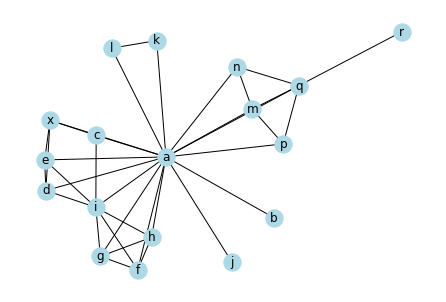

In [4]:
nx.draw(G, with_labels=True, node_color='lightblue')

In [5]:
def symmetric_difference(A: Set, B: Set) -> Set:
    return A.symmetric_difference(B)

def union(A: Set, B: Set) -> Set:
    return A.union(B)

def intersection(A: Set, B: Set) -> Set:
    return A.intersection(B)

def is_overlapping(A: Set, B: Set) -> bool:
    return bool(A & B) and bool(A - B) and bool(B - A)

In [6]:
def is_partive_family(S: Set, F: Iterable[Set]) -> bool:
    def f(C: Set) -> bool:
        is_in = C in F
        if not is_in: print(C)
        return is_in
    def g(C: Set) -> bool:
        is_not_in = C not in F
        if not is_not_in: print(C)
        return is_not_in
    res = True
    res &= f(S)
    res &= g(set())
    for x in S:
        res &= f({x})
    for A in F:
        for B in F:
            if is_overlapping(A, B):
                res &=  f(A & B)
                res &=  f(A - B)
                res &=  f(B - A)
                res &=  f(A | B)
                res &=  f(symmetric_difference(A, B))
    return res

S = {1, 2, 3, 4}
F = [{1}, {2}, {3}, {4}, {1, 2}, {2, 3}, {1, 3}, {1, 2, 3}, {1, 2, 3, 4}]
is_partive_family(S, F)

True

In [7]:
A = {1, 2, 3}
is_overlapping(A, A)

False

In [8]:
def is_strong(A, F) -> bool:
    assert A in F
    return all(not is_overlapping(A, B) for B in F)

In [9]:
def strong_elements(F: Iterable[Set]) -> List[Set]:
    return [A for A in F if is_strong(A, F)]

In [10]:
strong_elements(F)

[{1}, {2}, {3}, {4}, {1, 2, 3}, {1, 2, 3, 4}]

In [11]:
def is_factor(sigma: List[Any], I: Set) -> bool:
    ranks = {i for i, x in enumerate(sigma) if x in I}
    return ranks == {i for i in range(min(ranks), max(ranks) + 1)}

def is_factoring(F: Iterable[Set], sigma: List[Any]) -> bool:
    F_strong = strong_elements(F)
    return all(is_factor(sigma, F) for F in F_strong)

S = set(range(1, 8+1))
F = [S] + list(powerset({1, 2, 3})) + list(powerset({6, 7, 8})) + [{5}, {6}]
F = [A for A in F if len(A) > 0]

pi = list(S)
pi_1 = [6, 7, 8, 4, 3, 2, 1, 5]
pi_2 = [8, 7, 6, 1, 3, 2, 4, 5]

is_factor(pi, {3, 4, 5}), is_factoring(F, pi), is_factoring(F, pi_1), is_factoring(F, pi_2)

(True, True, True, True)

In [39]:
def neighborhood(G, x):
    return set(G.neighbors(x))

def non_neighborhood(G, x):
    return set(G.nodes() - G.neighbors(x) - {x})

def induced_subgraph(G: nx.Graph, X) -> nx.Graph:
    return G.subgraph(X)

def is_splitter(G, M, x) -> bool:
    assert x in G.nodes() - M
    for y in M:
        for z in M:
            if (x, y) in G.edges() and (x, z) not in G.edges():
                return True
    return False

def splitters(G, M) -> Iterable:
    return [u for u in G.nodes() if u not in M and is_splitter(G, M, u)]

def is_homogeneous(G, M, x) -> bool:
    return not is_splitter(G, M, x)

In [42]:
splitters(G, {"m", "n", "p"}), splitters(G, {"m", "p"})

([], ['n'])

In [ ]:
def is_module(G, M) -> bool:
    assert M.issubset(G.nodes())
    res = True
    for x in G.nodes() - M:
        Nx = neighborhood(G, x)
        res &= bool(M.issubset(Nx)) or (not bool(M & Nx))
    return res

def modules(G: nx.Graph) -> Iterable[Set]:
    return (M for M in powerset(G.nodes()) if is_module(G, M) and bool(M))

#is_module(G, {"l", "k"})

MG = list(modules(G))

In [13]:
len(strong_elements(MG)), len(MG)

(27, 40)

In [36]:
print("\n".join(sorted(["".join(sorted(M)) for M in strong_elements(MG)], key=lambda x: (len(x), x))))

a
b
c
d
e
f
g
h
i
j
k
l
m
n
p
q
r
x
de
kl
np
cde
fgh
mnp
cdefghix
bcdefghijklx
abcdefghijklmnpqrx


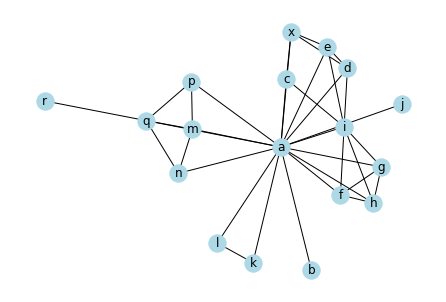

In [15]:
nx.draw(G, with_labels=True, node_color='lightblue')

In [16]:
def is_modular_partition(G: nx.Graph, P: Iterable[Set]) -> bool:
    assert set().union(*P) == set(G.nodes())
    assert sum(map(len, P)) == len(G.nodes())
    return all(is_module(G, M) for M in P)

def is_maximal_modular_partition(G: nx.Graph, P: Iterable[Set], *, precomp_modules=None) -> bool:
    if precomp_modules is None:
        precomp_modules = modules(G)
    return all(is_strong(M, precomp_modules) for M in P) and is_modular_partition(G, P)

is_maximal_modular_partition(G, [{"a"}, set("bcdefghijklx"), {"q"}, {"r"}, set("npm")], precomp_modules=MG)

True

In [17]:
def maximal_modular_partition(G: nx.Graph, *, precomp_strong_modules=None) -> Iterable[Set]:
    if precomp_strong_modules is None:
        precomp_strong_modules = strong_elements(list(modules(G)))
    precomp_strong_modules = list(sorted(precomp_strong_modules, key=len))
    precomp_strong_modules.pop()
    P = []
    while bool(precomp_strong_modules):
        P.append(precomp_strong_modules.pop())
        precomp_strong_modules = [M for M in precomp_strong_modules if not M.issubset(P[-1])]
    return P

P_max = maximal_modular_partition(G, precomp_strong_modules=strong_elements(MG))

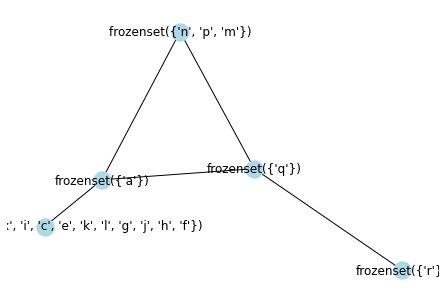

In [18]:
def quotient_graph(G: nx.Graph, P: Iterable[Set]) -> nx.Graph:
    assert is_modular_partition(G, P)
    return nx.quotient_graph(G, P)

G_P = quotient_graph(G, P_max)
nx.draw(G_P, with_labels=True, node_color='lightblue')

**Lemma 4.** Let $\mathcal{P}$ be a modular partition of a graph $G = (V, E)$. Then $\mathcal{X} \subset \mathcal{P}$ is a non-trivial strong module of $G_{/\mathcal{P}}$ iff $\bigcup_{M\in\mathcal{X}} M$ is a non-trivial strong module of G.

In [19]:
P = [{"a"}, set("cdefghix"), set("bjkl"), {"q"}, {"r"}, set("npm")]
assert is_modular_partition(G, P)

G_P = quotient_graph(G, P)
MG_P = list(modules(G_P))

for X in powerset(map(frozenset, P)):
    if len(X) == 0: continue
    X_union = set().union(*X)
    left = is_module(G_P, X) and is_strong(X, MG_P)
    right = is_module(G, X_union) and is_strong(X_union, MG)
    if left != right:
        print(X, len(X), is_module(G_P, X), is_strong(X, MG_P), X_union, len(X_union), is_module(G, X_union), is_strong(X_union, MG))
    #assert left == right

{frozenset({'b', 'k', 'j', 'l'})} 1 True True {'b', 'k', 'j', 'l'} 4 True False


/tmp/ipykernel_673306/1969896116.py:21: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.pydot_layout(H, prog='dot')


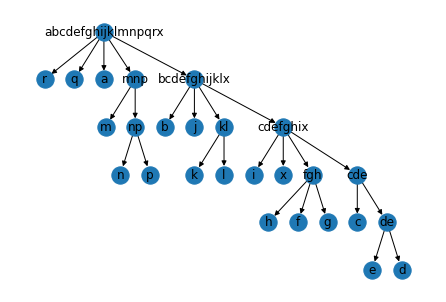

In [20]:
def modular_decomposition_tree(G: nx.Graph, *, precomp_strong_modules=None) -> nx.DiGraph:
    if precomp_strong_modules is None:
        precomp_strong_modules = strong_elements(list(modules(G)))
    precomp_strong_modules = list(map(frozenset, precomp_strong_modules))
    
    md_tree = nx.DiGraph()
    md_tree.add_nodes_from(precomp_strong_modules)
    parent = dict()
    for X in precomp_strong_modules:
        for Y in precomp_strong_modules:
            if X != Y and X.issubset(Y) and (X not in parent or len(parent[X]) > len(Y)):
                parent[X] = Y
    for X, Y in sorted(parent.items(), key=lambda kv: (kv[1], kv[0])):
        md_tree.add_edge(Y, X)
    return md_tree

MDG = modular_decomposition_tree(G, precomp_strong_modules=strong_elements(MG))

mapping = {X: "".join(sorted(X)) for X in MDG.nodes()}
H = nx.relabel_nodes(MDG, mapping, copy=True)
pos = nx.nx_pydot.pydot_layout(H, prog='dot')
nx.draw(H, pos=pos, with_labels=True)

# {a (b {(c (d e)) (f g h) i x} j (k l)) (m (n p)) q r}

In [21]:
def m(MDG: nx.DiGraph, x, y):
    """$m(x, y) := minimal strong module containing vertices x and y.$
    """
    return nx.lowest_common_ancestor(MDG, frozenset({x}), frozenset({y}))

def M(MDG: nx.DiGraph, x, y):
    """$M(x, \bar{y}) := maximal strong module containing vertex x but not y.$
    """
    ancestors = [frozenset({x})] + list(sorted(nx.ancestors(MDG, frozenset({x})), key=len))
    for i, a in enumerate(ancestors):
        if y in a:
            return ancestors[i-1]
    assert False

m(MDG, "c", "l"), M(MDG, "e", "l")

(frozenset({'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'x'}),
 frozenset({'c', 'd', 'e', 'f', 'g', 'h', 'i', 'x'}))

# 4. Partition refinement

**Algorithm 1.** Refine($\mathcal{P}, S$)

**Input:** A partition P of a set V and a subset $S \subseteq V$, called *pivot* set

**Output:** The coarsest partition refining $\mathcal{P}$ and stable for $S$

In [22]:
def refine(P: Iterable[Set], S: Set) -> Iterable[Set]:
    result = []
    for X in P:
        XS = X & S
        if bool(XS) and XS != X:
            result += [XS, X - S]
        else:
            result += [X]
    return result

refine([{1, 2, 3}, {4, 5}, {6, 7, 8}], {1, 3, 5, 7})

[{1, 3}, {2}, {5}, {4}, {7}, {6, 8}]

In [ ]:
ist max mod part sinnvoll? md tree anschauen und root node bewerten


# 5. Recursive computation of the modular decomposition tree

**Definition 9.** Let $v$ be an arbitrary vertex of a graph $G = (V, E)$. The *$v$-modular* partition is the following modular partition:

$\mathcal{M}(G, v) = \{v\} \cup \{M | M\text{ is a maximal module not containing }v\}$.

We define $\operatorname{spine}(G, v)$ as the modular decomposition tree $MD(G_{/\mathcal{M}(G,v)})$.

In [23]:
def v_modular_partition(G: nx.Graph, v) -> Iterable[Set]:
    M_G = list(modules(G))
    result = []
    for M in M_G:
        if v not in M:
            result = [X for X in result if not X.issubset(M)] + [M]
    return result + [{v}]

v_modular_partition(G, "a")

[{'r'},
 {'q'},
 {'m', 'n', 'p'},
 {'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'x'},
 {'a'}]

In [24]:
def spine(G: nx.Graph, v) -> nx.DiGraph:
    G_MGv = quotient_graph(G, v_modular_partition(G, v))
    tree = modular_decomposition_tree(G_MGv)
    def mapping(X):
        return frozenset(set().union(*X))
    tree = nx.relabel_nodes(tree, mapping, copy=True)
    return tree

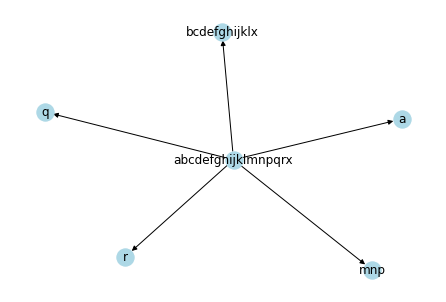

In [25]:
spine_G_a = spine(G, "a")
nx.draw(nx.relabel_nodes(spine_G_a, lambda x: "".join(sorted(x))), with_labels=True, node_color='lightblue')

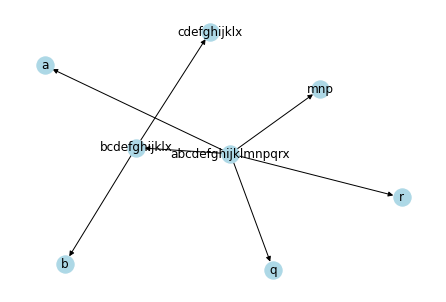

In [26]:
spine_G_b = spine(G, "b")
nx.draw(nx.relabel_nodes(spine_G_b, lambda x: "".join(sorted(x))), with_labels=True, node_color='lightblue')

In [27]:
def is_nested(G: nx.Graph) -> bool:
    non_trivial_modules = list(modules(G))
    for x in G.nodes():
        non_trivial_modules.remove({x})
    non_trivial_modules.remove(set(G.nodes()))
    return any(all(x in M for M in non_trivial_modules) for v in G.nodes())

is_nested(G)

False

In [28]:
def non_trivial_modules(G: nx.Graph, *, precomputed_modules=None) -> Iterable[Set]:
    if precomputed_modules is None:
        M_G_non_trivial = list(modules(G))
    else:
        M_G_non_trivial = list(precomputed_modules)
    for x in G.nodes():
        M_G_non_trivial.remove({x})
    M_G_non_trivial.remove(set(G.nodes()))
    return M_G_non_trivial

In [29]:
def is_inner_vertex(G: nx.Graph, v, *, precomputed_modules=None) -> bool:
    M_G_non_trivial = non_trivial_modules(G, precomputed_modules=precomputed_modules)
    return all(v in M for M in M_G_non_trivial)

In [43]:
for v in tqdm(list(G.nodes())):
    G_MGv = quotient_graph(G, v_modular_partition(G, v))
    assert is_inner_vertex(G_MGv, {v})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:50<00:00,  2.80s/it]


In [ ]:
G_MGn = quotient_graph(G, v_modular_partition(G, "n"))

In [ ]:
nx.draw(nx.relabel_nodes(G_MGn, lambda x: "".join(sorted(x))), with_labels=True, node_color='lightblue')

In [ ]:
strong_elements(list(modules(G_MGn))), non_trivial_modules(G_MGn)

In [ ]:
M_G_MGn = list(modules(G_MGn))
M_G_MGn.remove(set(G_MGn.nodes()))
for x in G_MGn.nodes():
    M_G_MGn.remove({x})


[({"n"} in M, M) for M in M_G_MGn]

In [ ]:
nx.draw(G_MGn, with_labels=True)